In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
cd /content/drive/MyDrive/WORK/XID_plus

/content/drive/MyDrive/WORK/XID_plus


In [4]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import numpy as onp



from functools import partial # for use with vmap
from jax import jit # for compiling functions for speedup
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax, LeakyRelu # neural network layers

from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays 
import matplotlib.pyplot as plt # visualization
# Generate key which is used to generate random numbers
key = random.PRNGKey(1)


/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')
  gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!
Tue May 17 12:50:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    32W / 250W |  14679MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
    

In [6]:
from astropy.table import Table, vstack

In [7]:
data=Table.read('./docs/notebooks/examples/SED_emulator/kasia_gen_SEDs_zall.fits')

In [8]:
data['log10_sfh.sfr']=onp.log10(data['sfh.sfr'])
data['log10_universe.redshift']=onp.log10(data['universe.redshift'])
data['log10_dust.luminosity']=onp.log10(data['dust.luminosity'])
data['log10_sfh.tau_main']=onp.log10(data['sfh.tau_main'])
data['log10_sfh.age_main']=onp.log10(data['sfh.age_main'])
data['log10_attenuation.Av_BC']=onp.log10(data['attenuation.Av_BC'])
data['log10_stellar.m_star']=onp.log10(data['stellar.m_star'])



## DeepNet building
I will build a multi input, multi output deepnet model as my emulator, with parameters as input and the observed flux as outputs. I will train on log10 flux to make the model easier to train, and have already standarised the input parameters. I wilkl be using `stax` which can be thought of as the `Keras` equivalent for `JAX`. This [blog](https://blog.evjang.com/2019/02/maml-jax.html) was useful starting point.

In [9]:
data.colnames[1:10]

['irac_i1',
 'omegacam_g',
 'omegacam_i',
 'omegacam_r',
 'omegacam_u',
 'omegacam_z',
 'spire_250',
 'spire_350',
 'spire_500']

In [18]:
#init_input_cols=['log10_sfh.sfr','agn.fracAGN','universe.redshift', 'attenuation.Av_BC','dust.alpha','log10_sfh.tau_main','log10_sfh.age_main']
init_input_cols=['log10_sfh.sfr','agn.fracAGN','universe.redshift', 'attenuation.Av_BC','dust.alpha','log10_sfh.tau_main']#,'log10_stellar.m_star']

output_cols=data.colnames[1:10]

In [19]:
for i in output_cols:
  ind=data[i]<=0.0
  print(ind.sum())
  data[i][ind]=1.0E-30

0
0
0
0
0
0
0
0
0


In [20]:
len(data)

155520

I will use batches to help train the network

In [22]:
inner_batch_size=1000

train_ind=onp.round(130000).astype(int)
val_ind=onp.round(155000)
train=data[0:train_ind]

validation=data[train_ind:val_ind]
input_cols=init_input_cols#['std_'+s for s in init_input_cols]
train_batch_X=np.asarray([i.data for i in train[input_cols].values()]).reshape(len(input_cols)
                                                                               ,inner_batch_size,onp.round(len(train)/inner_batch_size).astype(int)).T.astype(float)
train_batch_Y=np.asarray([np.log(i.data.astype('f8')) for i in train[output_cols].values()]).reshape(len(output_cols),
                                                                                          inner_batch_size,onp.round(len(train)/inner_batch_size).astype(int)).T.astype(float)
validation_batch_X=np.asarray([i.data for i in validation[input_cols].values()]).reshape(len(input_cols)
                                                                               ,inner_batch_size,onp.round(len(validation)/inner_batch_size).astype(int)).T.astype(float)
validation_batch_Y=np.asarray([np.log(i.data.astype('f8')) for i in validation[output_cols].values()]).reshape(len(output_cols),
                                                                                          inner_batch_size,onp.round(len(validation)/inner_batch_size).astype(int)).T.astype(float)


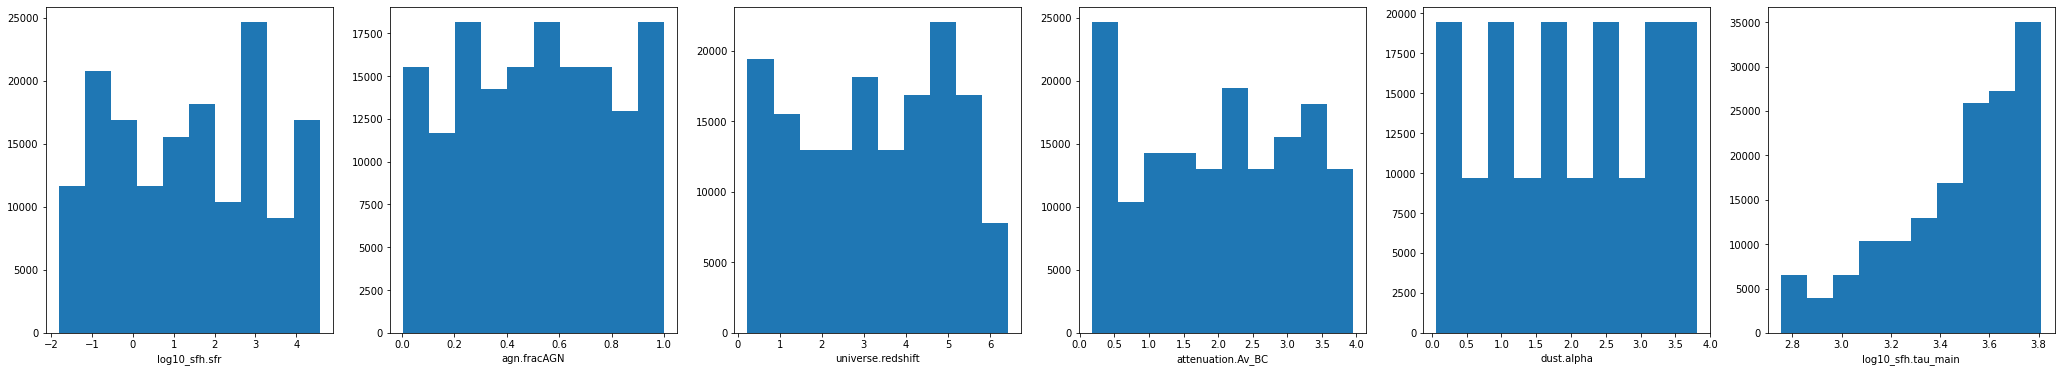

In [23]:
fig,axes=plt.subplots(1,len(input_cols),figsize=(6*len(input_cols),6))
for i in range(0,len(input_cols)):
  axes[i].hist(data[input_cols[i]])
  axes[i].set_xlabel(input_cols[i])

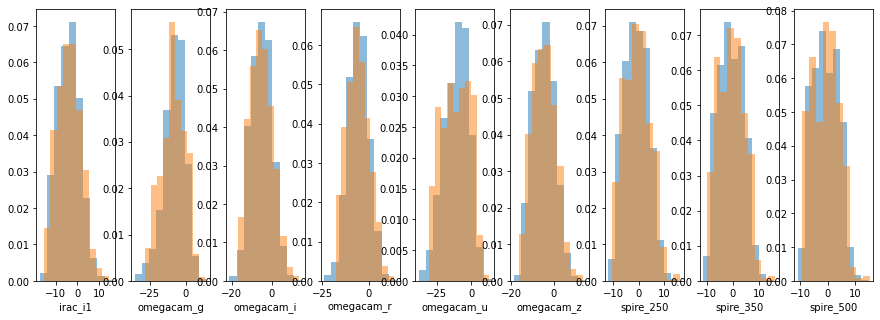

In [24]:
fig,axes=plt.subplots(1,9,figsize=(15,5))

for i in range(0,9):
  axes[i].hist(train_batch_Y[:,:,i].flatten()[onp.isfinite(train_batch_Y[:,:,i].flatten())],alpha=0.5,density=True)
  axes[i].hist(validation_batch_Y[:,:,i].flatten()[np.isfinite(validation_batch_Y[:,:,i].flatten())],alpha=0.5,density=True)
  axes[i].set_xlabel(output_cols[i])
  

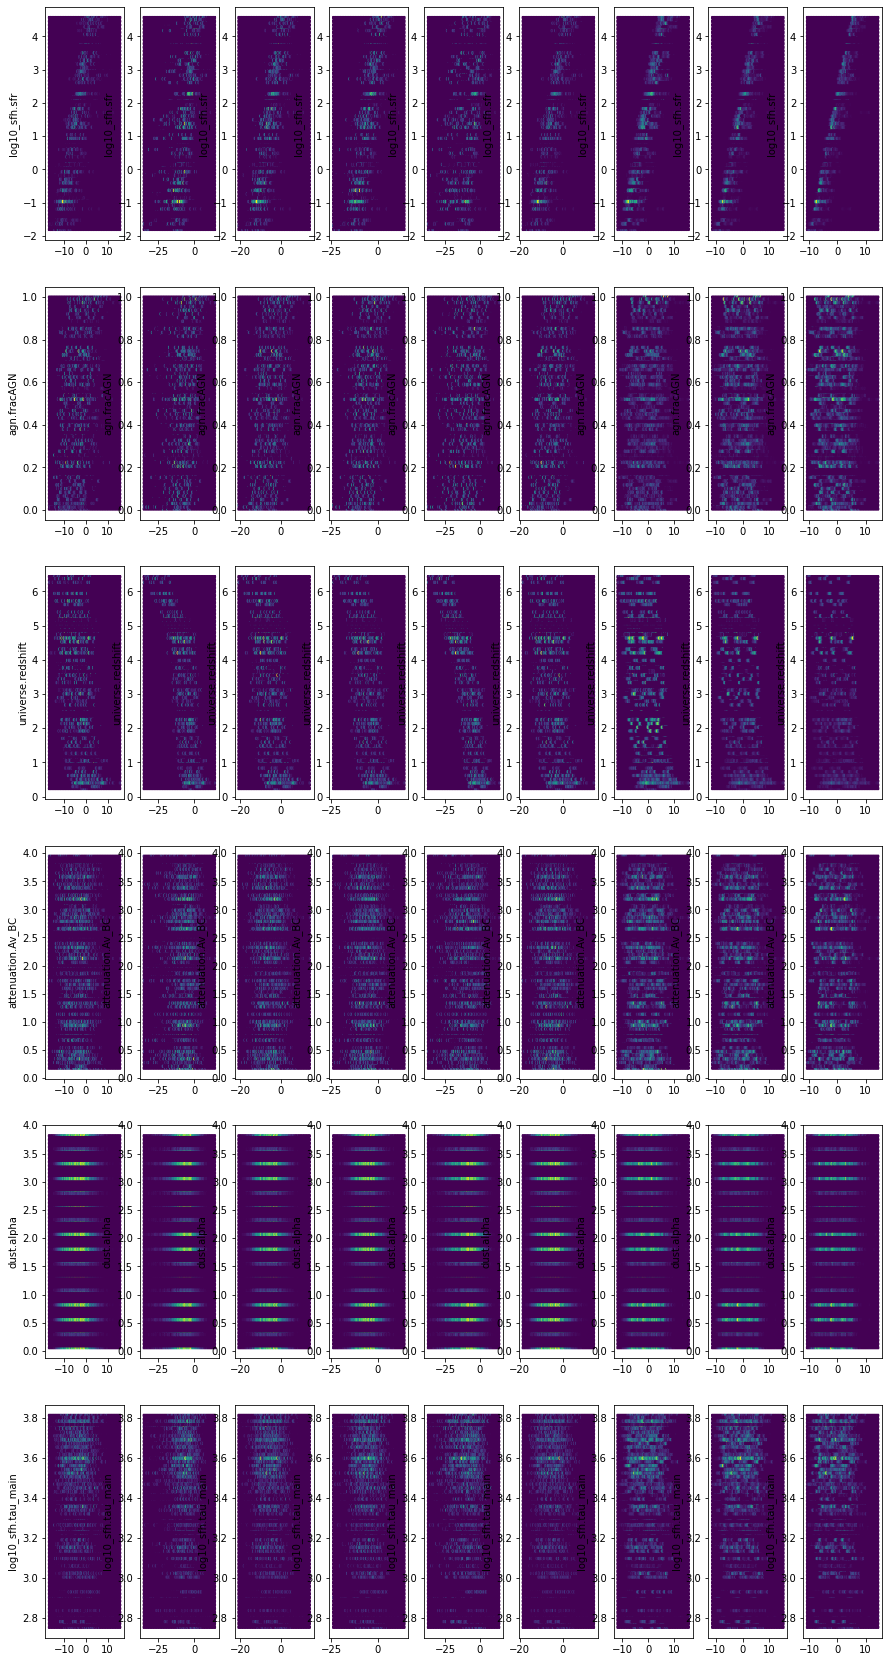

In [25]:
fig,axes=plt.subplots(len(input_cols),len(output_cols),figsize=(15,len(input_cols)*5))

for i in range(0,len(output_cols)):
  for j in range(0,len(input_cols)):
    axes[j,i].hexbin(train_batch_Y[:,:,i].flatten(),train_batch_X[:,:,j].flatten())
    axes[j,i].set_ylabel(input_cols[j])

In [26]:
def loss(params, inputs, targets):
    # Computes average loss for the batch
    predictions = net_apply(params, inputs)
    return np.mean((targets - predictions)**2)

def batch_loss(p,x_b,y_b):
    loss_b=vmap(partial(loss,p))(x_b,y_b)
    return np.mean(loss_b)

@jit
def step(i, opt_state, x1, y1):
    p = get_params(opt_state)
    g = grad(batch_loss)(p, x1, y1)
    loss_tmp=batch_loss(p,x1,y1)
    return opt_update(i, g, opt_state),loss_tmp,g

In [27]:
nodes=[128]
n_iter=40000

np_batched_loss_2 = onp.zeros((n_iter,len(nodes)))
valid_loss2= onp.zeros((n_iter,len(nodes)))
net_params_all=[]

for n in range(0,len(nodes)):
  # Use stax to set up network initialization and evaluation functions
  net_init, net_apply = stax.serial(
      Dense(nodes[n]), LeakyRelu,
      Dense(nodes[n]), LeakyRelu,
      Dense(nodes[n]), LeakyRelu,
      Dense(nodes[n]), LeakyRelu,
      Dense(len(output_cols))
  )
  
  in_shape = (-1, len(input_cols),)
  opt_init, opt_update, get_params= optimizers.adam(step_size=5e-4)
  out_shape, net_params = net_init(key,in_shape)
  opt_state = opt_init(net_params)
  p = get_params(opt_state)
  for i in range(n_iter):
      opt_state, l,g = step(i, opt_state, train_batch_X, train_batch_Y)
      p = get_params(opt_state)
      
      valid_loss2[i,n]=batch_loss(p,validation_batch_X,validation_batch_Y)
      np_batched_loss_2[i,n]=l
      if i % 1000 == 0:
        print(i,n,l)

  net_params_all.append(get_params(opt_state))

0 0 64.08253
1000 0 0.3262349
2000 0 0.10599325
3000 0 0.05030085
4000 0 0.033957124
5000 0 0.026448121
6000 0 0.025864275
7000 0 0.016162984
8000 0 0.01380014
9000 0 0.012309392
10000 0 0.010599017
11000 0 0.009607047
12000 0 0.008818301
13000 0 0.0077247364
14000 0 0.0071006846
15000 0 0.008224142
16000 0 0.0069752987
17000 0 0.021845251
18000 0 0.0052463985
19000 0 0.008850241
20000 0 0.00506035
21000 0 0.004601103
22000 0 0.0046059005
23000 0 0.0037935907
24000 0 0.0036970037
25000 0 0.0035838971
26000 0 0.0034945717
27000 0 0.007862401
28000 0 0.0060358397
29000 0 0.0029381884
30000 0 0.014006103
31000 0 0.0027855863
32000 0 0.0028726093
33000 0 0.0026163869
34000 0 0.0025180166
35000 0 0.00245743
36000 0 0.008480286
37000 0 0.0023740218
38000 0 0.0085836025
39000 0 0.0022647372


In [ ]:
import seaborn as sns

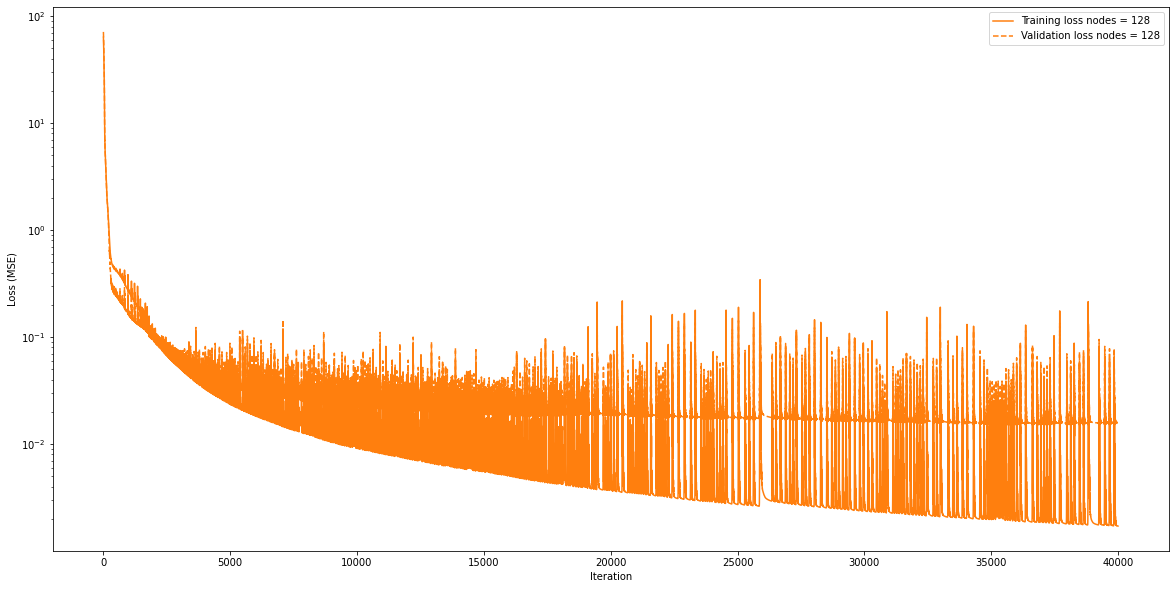

In [ ]:
plt.figure(figsize=(20,10))
colors=sns.color_palette("tab10")
for n in range(0,len(nodes)):
  #plt.semilogy(np_batched_loss_1[:,n],label='Training loss nodes = {}'.format(nodes[n]),color=colors[n])
  #plt.semilogy(valid_loss[:,n],label='Validation loss nodes = {}'.format(nodes[n]),color=colors[n],linestyle='--')
  plt.semilogy(np_batched_loss_2[:,n],label='Training loss nodes = {}'.format(nodes[n]),color=colors[1])
  plt.semilogy(valid_loss2[:,n],label='Validation loss nodes = {}'.format(nodes[n]),color=colors[1],linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Loss (MSE)')
plt.legend()

In [ ]:
valid_loss2[-10:]

array([[0.01582148],
       [0.01582557],
       [0.01581624],
       [0.01582567],
       [0.01581164],
       [0.01582526],
       [0.01580691],
       [0.0158254 ],
       [0.0158011 ],
       [0.0158256 ]])

## Investigate performance of each band of emulator
To visulise performance of the trainied emulator, I will show the difference between real and emulated for each band.

In [30]:
net_params = get_params(opt_state)
predictions = net_apply(net_params,validation_batch_X)

In [47]:
axes.flatten()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0e8344fd0>,
      dtype=object)

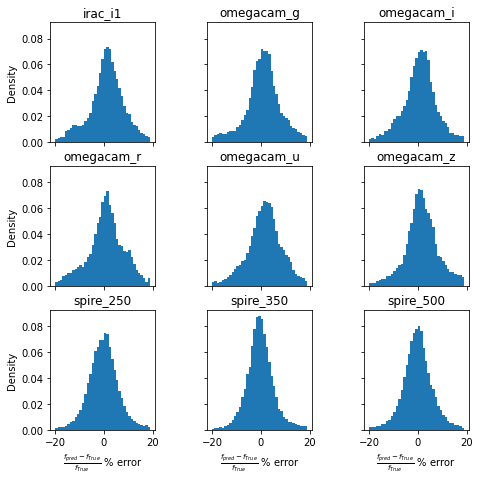

In [51]:
res=((np.exp(predictions))-(np.exp(validation_batch_Y)))/np.exp(validation_batch_Y)
fig,axes=plt.subplots(3,3,figsize=(2.5*3,2.5*3),sharey=True,sharex=True)
for i,a in zip(range(0,len(output_cols)),axes.flatten()):
    a.hist(res[:,:,i].flatten()*100.0,bins=np.arange(-20,20),density=True)
    a.set_title(output_cols[i])
    if i>5:
      a.set_xlabel(r'$\frac{f_{pred} - f_{True}}{f_{True}} \ \%$ error')
    if i%3==0:
      a.set_ylabel("Density")
plt.subplots_adjust(wspace=0.5)

In [ ]:
a=predictions[:,:,6].flatten()
b=validation_batch_Y[:,:,6].flatten()

In [ ]:
plt.hist(predictions[:,:,1].flatten(),alpha=0.5)
plt.hist(validation_batch_Y[:,:,1].flatten(),alpha=0.5)

In [ ]:
plt.scatter(a,b)

In [ ]:
#onp.savez('./docs/notebooks/examples/SED_emulator/CIGALE_emulator_kasia_20220304_mstar',net_params,allow_pickle=True)

In [ ]:
 plt.loglog([0.1,0.3,0.5,0.6,0.7,3.6,250.,350.0,500],np.exp(net_apply(net_params,np.array([3,0.0,1.0,3.0,3.0,3,3.1]))),'o')

In [ ]:
['log10_sfh.sfr','agn.fracAGN','universe.redshift', 'attenuation.Av_BC','dust.alpha','log10_sfh.tau_main','log10_sfh.age_main']